<div style="float:left">
    <h1 style="width:1000px">Impact of Trip Characteristics and Time on Tips:</h1>
    <p style="color:DimGray; text-align:left; font-size:20px"><i> Analysis of NYC Green Taxi Data from February 2024 </i></p>
    <p style="color:DimGray; text-align:left; font-size:20px"><i> Author: Yunlong Li </i></p>
    <p style="color:DimGray; text-align:left; font-size:20px"><i> Word count: 2184 </i></p>
</div>
<div style="float:right"><img width="100" src="https://github.com/jreades/i2p/raw/master/img/casa_logo.jpg" /></div>

***
#### About this document
_This is the assignment for the UCL CASA module Data Science for Spatial Systems (CASA0006) <br>This is a self contained Jupyter notebook with structure introduction, discussion and embeded code and bibliography._
<br>
**Code is hosted [here](https://github.com/gordenleee/DSSS_Assessment/tree/main)**<br>
**Data is availble [here](https://github.com/gordenleee/DSSS_Assessment/tree/main/Data)**
***

<a id="ID_intr"></a>
| [1.0 Intro](#ID_intr) | [2.0 Lit. review & RQ](#ID_lit) | [3.0 Method](#ID_method) | [4.0 Data](#ID_data) | [5.0 Explore]("#section_ID") | [6.0 Analysis](#ID_Intro) | [7.0 Results]("#section_ID") | [8.0 Discussion](#ID_Intro) | [Bibliography](#ID_Intro) | [Appendix](#ID_Intro) |

## 1.0 | Introduction

This study explores the impact of green taxi service on driver tip income in New York City. Green taxis play an important role in transport services and environmental protection, especially filling service gaps in areas not covered by yellow taxis. However, there is a lack of clarity on the factors influencing tipping. By analysing taxi data from February 2024, this study uses statistical analysis to reveal the impact of trip characteristics and time of day on tipping income. Using principal component analysis and panel regression to process the data, the study aims to provide insights into the impact of driver income and time of service on market behaviour. The article discusses in detail the research methodology, data processing choices, and analysis of results, with a code section explaining the analysis steps that complement the methodology and results.

### 1.1 | Requirements to run the analysis

An overview of packages used to run the analysis with brief explanation of their role.

In [1]:
import warnings  # Python warnings control
warnings.filterwarnings("ignore")  # Ignore all warnings

In [2]:
# Hide the download information of the package
try:
    from linearmodels import PanelOLS  # Try importing PanelOLS from linearmodels
except ModuleNotFoundError:  # If it's not found
    import subprocess  # Import subprocess module for running shell commands
    subprocess.run(["pip", "install", "linearmodels"], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)  # Install linearmodels package using pip
    from linearmodels import PanelOLS  # Now import PanelOLS

In [3]:
import io  # Input/output operations, used for handling data streams
import requests  # HTTP library for making requests to web servers
import pyarrow.parquet as pq  # Library for reading and writing Parquet files
import pandas as pd  # Data manipulation and analysis library
from sklearn.preprocessing import StandardScaler  # Preprocessing module for standardizing features
from sklearn.decomposition import PCA  # Principal Component Analysis for dimensionality reduction
import matplotlib.pyplot as plt  # Plotting library for creating visualizations
import numpy as np  # Numerical computing library
import seaborn as sns  # Statistical data visualization library
import matplotlib.pyplot as plt  # Plotting library for creating visualizations
from statsmodels.tsa.stattools import adfuller  # Augmented Dickey-Fuller test for stationarity
from statsmodels.stats.stattools import durbin_watson  # Durbin-Watson test for autocorrelation
import statsmodels.api as sm  # Statistical models and tests
from statsmodels.stats.diagnostic import het_breuschpagan, het_white  # Tests for heteroscedasticity
from statsmodels.api import OLS  # Ordinary Least Squares regression
from linearmodels.panel import compare  # Compare panel models
from linearmodels.panel import RandomEffects  # Random Effects panel model
from linearmodels.iv import IV2SLS  # Instrumental Variable 2-Stage Least Squares
import scipy.stats as stats  # Scientific computing and statistics library

<a id="ID_lit"></a>
| [1.0 Intro](#ID_intr) | [2.0 Lit. review & RQ](#ID_lit) | [3.0 Method](#ID_method) | [4.0 Data](#ID_data) | [5.0 Explore]("#section_ID") | [6.0 Analysis](#ID_Intro) | [7.0 Results]("#section_ID") | [8.0 Discussion](#ID_Intro) | [Bibliography](#ID_Intro) | [Appendix](#ID_Intro) |

## 2.0 | Literature review and research question

**Literature**<br>
The purpose of this study is to examine how trip characteristics and time factors affect drivers' tip income in New York City's green taxis. By examining relevant prior research, we deepened our understanding of how trip characteristics, timing, and other external conditions affect taxi service and tipping practices.

Findings from Prior Research

Corrêa and Moyano (2022) examined the competitive landscape between Uber and green taxis in the outer boroughs of New York City and found significant changes in consumer preferences and underlying factors of taxi use that may affect tipping behaviour. Their study highlights the importance of understanding transport market dynamics to predict tipping trends.

Mojtabaee et al. (2019) used origin-destination GPS data from New York City's Green Cabs to delve into the key factors that underlie high-tipping trips. These factors may be associated with increased tipping, and this study will further explore how these factors influence tipping behaviour.

Al-Wreikat, Serrano, and Sodré (2022) analysed how ambient temperature and trip characteristics affect the energy consumption of electric vehicles. Although primarily focused on energy consumption, their study indirectly supports the exploration of how external conditions such as time of day affect driver operation and subsequent tipping patterns.
Research Questions and Sub-Questions

**Data and enquiry**<br>

In a detailed study, Poulsen et al. (2016) examined the dynamics of competition between green taxis and Uber, with a particular focus on the performance of green taxis in the rapidly changing landscape of taxi services in New York City. Their findings suggest significant changes in the market that are critical to understanding the economic pressures and opportunities in the green taxi industry.

Therefore, this leads to the primary research questions of:

    RQ  | How do trip characteristics and time of day factors affect tip income of green taxi drivers in New York City?

The study is further subdivided into the following sub-questions to delve deeper into different aspects of the impact:

    RQ1 | How do trip distance, total cost, other, etc. costs affect tipping?
    RQ2 | How do different times of the day (e.g., morning rush, evening rush, nighttime) and different days of the week affect tipping?

<a id="ID_method"></a>
| [1.0 Intro](#ID_intr) | [2.0 Lit. review & RQ](#ID_lit) | [3.0 Method](#ID_method) | [4.0 Data](#ID_data) | [5.0 Explore]("#section_ID") | [6.0 Analysis](#ID_Intro) | [7.0 Results]("#section_ID") | [8.0 Discussion](#ID_Intro) | [Bibliography](#ID_Intro) | [Appendix](#ID_Intro) |

## 3.0 | Methodology

In this study, we used two statistical methods, Principal Component Analysis (PCA) and Panel Regression, to analyse open data from New York City's green taxis, with the aim of exploring how trip characteristics and time of day affect drivers' tip income. A detailed description of the selection and application of these methods is provided below:

Principal Component Analysis (PCA)<br>
Principal Component Analysis (PCA) is a commonly used unsupervised learning technique for dimensionality reduction of data while preserving as much variability as possible in the original data. In this project, as the taxi dataset contains several potentially relevant variables (e.g. journey distance, time, cost, etc.), the use of PCA can effectively extract key features from this high-dimensional data and simplify the subsequent analysis process. By converting to a few principal components, it not only reduces computational complexity, but also helps to reveal the intrinsic relationships between variables (Shlens, 2014; Jolliffe & Cadima, 2016).

Panel Regression<br>
Panel regression is a statistical technique for dealing with multidimensional data arrays and is particularly suitable for analysing the combination of cross-sectional data and time-series data. In this study, panel regression was chosen to analyse the relationship between a dependent variable (e.g., tip amount) and multiple independent variables (e.g., trip distance and time of day, etc.), taking into account possible individual heterogeneity and time effects in the data. This method allows us to control for unobservable heterogeneity and thus estimate more accurately the effect of the explanatory variables on the dependent variable (Ray & Goel, 2022; Khalil et al., 2022).

Data processing flow<br>
The analysis process begins with the extraction of data from the raw files, followed by transformation, cleaning and aggregation to achieve the desired data resolution and to prepare it for the use of the statistical methods described above. During the data preprocessing stage, key steps such as removing outliers and dealing with missing data are performed to ensure data quality and accuracy of the analysis results (Phan et al., 2023).

Code Implementation and Reuse<br>
To enhance code reusability, most of the data processing and analysis functions are encapsulated in reused functions. While reading the code itself is not required, it provides additional context about the data manipulation steps. Analyses are self-contained and include hints for the reader to modify and run to observe changes in the output/report; these operations are optional (Reid et al., 2022).

<a id="ID_data"></a>
| [1.0 Intro](#ID_intr) | [2.0 Lit. review & RQ](#ID_lit) | [3.0 Method](#ID_method) | [4.0 Data](#ID_data) | [5.0 Explore]("#section_ID") | [6.0 Analysis](#ID_Intro) | [7.0 Results]("#section_ID") | [8.0 Discussion](#ID_Intro) | [Bibliography](#ID_Intro) | [Appendix](#ID_Intro) |

## 4.0 | Presentation of data

The original dataset includes an overview of trip log data from the NYC Taxi and Limousine Commission (TLC) for yellow and green taxis and For-Hire Vehicles (FHVs). The code below performs data cleaning and preprocessing. Due to computer running memory limitations, we focus here on February 2024 data for green taxis, but the entire dataset can be downloaded [here](https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page).

In [4]:
# Download the Parquet file from the specified URL
url = "https://github.com/gordenleee/DSSS_Assessment/raw/main/Data/green_tripdata_2024-02.parquet"
response = requests.get(url)

# Read the downloaded content as a Parquet file
parquet_file = io.BytesIO(response.content)

# Read the Parquet file and load it into a Pandas DataFrame
green_taxi_data = pq.read_table(parquet_file)
green_taxi_data = green_taxi_data.to_pandas()

In [5]:
# Display the first few rows of the dataframe
print(green_taxi_data.head())

# Get summary information about the dataframe
green_taxi_data.info()

# Get summary statistics of the dataframe
print(green_taxi_data.describe())

   VendorID lpep_pickup_datetime lpep_dropoff_datetime store_and_fwd_flag  \
0         2  2024-02-01 00:15:53   2024-02-01 00:24:20                  N   
1         2  2024-01-31 22:59:22   2024-01-31 23:27:14                  N   
2         2  2024-02-01 00:30:29   2024-02-01 00:35:32                  N   
3         2  2024-01-31 23:56:42   2024-02-01 00:06:53                  N   
4         2  2024-02-01 00:31:14   2024-02-01 00:31:16                  N   

   RatecodeID  PULocationID  DOLocationID  passenger_count  trip_distance  \
0         1.0            75           161              1.0           2.77   
1         1.0            43           242              1.0           7.76   
2         1.0            75           238              1.0           1.03   
3         1.0            80            17              2.0           1.36   
4         5.0            95           264              1.0           0.00   

   fare_amount  extra  mta_tax  tip_amount  tolls_amount  ehail_fee  \
0  

**Key field**<br>

We can see the basic structure of the data and a sample of the first few rows. Here are some key fields and their data types:

`VendorID`: Vendor ID (integer)
`lpep_pickup_datetime`: pickup time (string)

`lpep_dropoff_datetime`: drop-off time (string)

`RatecodeID`: Rate code (floating point)

`PULocationID` and `DOLocationID`: ID of the boarding and alighting location (integer)

`trip_distance`: trip distance (floating point)

`fare_amount`: fare (floating point)

`extra`, `mta_tax`, `tip_amount`, `tolls_amount`, `improvement_surcharge`, `total_amount`: Various fees and total fees (floating point)

<a id="ID_explore"></a>
| [1.0 Intro](#ID_intr) | [2.0 Lit. review & RQ](#ID_lit) | [3.0 Method](#ID_method) | [4.0 Data](#ID_data) | [5.0 Explore]("#section_ID") | [6.0 Analysis](#ID_Intro) | [7.0 Results]("#section_ID") | [8.0 Discussion](#ID_Intro) | [Bibliography](#ID_Intro) | [Appendix](#ID_Intro) |

## 5.0 | Data cleaning and preprocessing

#### Data preparation and pre-processing
Data quality is fundamental to ensure the validity of the analyses. Therefore, we thoroughly cleaned and pre-processed the data in the following key steps:

**Data format conversion**: We normalised all date-time fields into a format suitable for time series analysis.

**Missing value handling**: By removing rows or columns containing missing values, we ensure the completeness and accuracy of the analysis.

**Outliers and Error Data Handling**: By identifying and processing or removing unjustified data records (such as negative costs or impossible trip distances), we improve the overall quality of the dataset.

#### Statistical analysis and feature engineering
In order to gain a deeper understanding of patterns and trends in the data, we performed a series of statistical analyses and feature engineering:

**Descriptive statistics and outlier handling**: By calculating descriptive statistics for key variables and applying IQR methods to handle outliers, we were able to obtain a more accurate and representative distribution of the data.

**Data consistency checking**: we compare the calculated totals with those in the records to ensure data accuracy and consistency.

**Introduction of temporal features**: By flagging peak hour and night-time journeys in the data, and analysing the pattern of journeys on different days of the week, we increased our understanding of the dynamics of journey times.

#### **Data types**

**Convert datetime fields**: converts `lpep_pickup_datetime` and `lpep_dropoff_datetime` from string to datetime format for time series analysis.

In [6]:
# Convert 'lpep_pickup_datetime' and 'lpep_dropoff_datetime' to datetime format
green_taxi_data['lpep_pickup_datetime'] = pd.to_datetime(green_taxi_data['lpep_pickup_datetime'])
green_taxi_data['lpep_dropoff_datetime'] = pd.to_datetime(green_taxi_data['lpep_dropoff_datetime'])

# Check the data types again to confirm the conversion
green_taxi_data.dtypes

VendorID                          int32
lpep_pickup_datetime     datetime64[us]
lpep_dropoff_datetime    datetime64[us]
store_and_fwd_flag               object
RatecodeID                      float64
PULocationID                      int32
DOLocationID                      int32
passenger_count                 float64
trip_distance                   float64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
ehail_fee                       float64
improvement_surcharge           float64
total_amount                    float64
payment_type                    float64
trip_type                       float64
congestion_surcharge            float64
dtype: object

#### **Missing value handling**

Each column was checked for missing values and the `ehail_fee` column was removed as it contained more missing values and was not necessary for the analysis.

For columns with a small number of missing values, such as `store_and_fwd_flag`, `RatecodeID`, `passenger_count`, `payment_type`, `trip_type`, `congestion_surcharge`, the rows where these missing values are located are simply deleted.

In [7]:
# Checking for missing values in each column
missing_values = green_taxi_data.isnull().sum()
missing_values[missing_values > 0]

store_and_fwd_flag       2928
RatecodeID               2928
passenger_count          2928
ehail_fee               53577
payment_type             2928
trip_type                2933
congestion_surcharge     2928
dtype: int64

In [8]:
# Drop the 'ehail_fee' column
green_taxi_data.drop('ehail_fee', axis=1, inplace=True)

# Drop rows with missing values in other columns with few missing entries
green_taxi_data.dropna(subset=['store_and_fwd_flag', 'RatecodeID', 'passenger_count', 'payment_type', 
                               'trip_type', 'congestion_surcharge'], inplace=True)

# Confirm the cleaning by checking missing values again
green_taxi_data.isnull().sum()

VendorID                 0
lpep_pickup_datetime     0
lpep_dropoff_datetime    0
store_and_fwd_flag       0
RatecodeID               0
PULocationID             0
DOLocationID             0
passenger_count          0
trip_distance            0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
payment_type             0
trip_type                0
congestion_surcharge     0
dtype: int64

#### **Outliers and Error Data Handling**

Computes descriptive statistics for key numeric fields (such as `trip_distance`, `fare_amount`, `tip_amount`, and `total_amount`) to identify and remove outliers from them.

In [9]:
# Calculate descriptive statistics for numerical fields of interest
statistical_summary = green_taxi_data[['trip_distance', 'fare_amount', 'tip_amount', 'total_amount']].describe()
statistical_summary

,trip_distance,fare_amount,tip_amount,total_amount
count,50644.000000,50644.000000,50644.000000,50644.000000
mean,2.521316,16.597506,2.306747,22.210899
std,2.754812,14.673902,3.064442,16.521542
min,0.000000,-85.000000,-0.010000,-86.000000
25%,1.090000,9.300000,0.000000,13.300000
50%,1.750000,12.800000,2.000000,18.200000
75%,2.970000,19.100000,3.550000,26.250000
max,99.280000,955.700000,222.000000,957.200000


Removed records with negative values for `fare_amount`, `tip_amount`, `total_amount`, and records with zero or unusually high `trip_distance` (more than the mean plus three times the standard deviation).

#### **Statistical Descriptive Recalculation**

Recalculates descriptive statistics on the cleaned data to ensure that the data is cleaned.

In [10]:
# Removing records where fare_amount, tip_amount, or total_amount are negative
green_taxi_data = green_taxi_data[(green_taxi_data['fare_amount'] >= 0) & 
                                  (green_taxi_data['tip_amount'] >= 0) & 
                                  (green_taxi_data['total_amount'] >= 0)]

# Removing records where trip_distance is zero or excessively high (more than 3 standard deviations from the mean)
mean_distance = statistical_summary.loc['mean', 'trip_distance']
std_distance = statistical_summary.loc['std', 'trip_distance']
high_distance_threshold = mean_distance + 3 * std_distance

green_taxi_data = green_taxi_data[(green_taxi_data['trip_distance'] > 0) &
                                  (green_taxi_data['trip_distance'] <= high_distance_threshold)]

# Re-checking the descriptive statistics for cleaned data
cleaned_statistical_summary = green_taxi_data[['trip_distance', 'fare_amount', 'tip_amount', 'total_amount']].describe()
cleaned_statistical_summary

,trip_distance,fare_amount,tip_amount,total_amount
count,46808.00000,46808.000000,46808.000000,46808.000000
mean,2.40813,15.261815,2.287840,20.874213
std,1.87857,9.199276,2.708562,11.239991
min,0.01000,0.000000,0.000000,0.000000
25%,1.19000,9.300000,0.000000,13.220000
50%,1.81000,12.800000,2.000000,17.940000
75%,2.97000,18.400000,3.560000,25.500000
max,10.77000,245.000000,222.000000,246.000000


`trip_distance`: the maximum trip distance is now 10.77 miles, which is more reasonable than the previous 99.28 miles. The minimum distance is 0.01 miles, showing that all trip distances are greater than 0.

`fare_amount`, `tip_amount` and `total_amount`: all negative values have been removed and the data now looks more reasonable.

#### **Outliers are further dealt with**

Outliers in key numerical variables identified during the EDA (Exploratory Data Analysis) process are handled using the interquartile method (IQR).

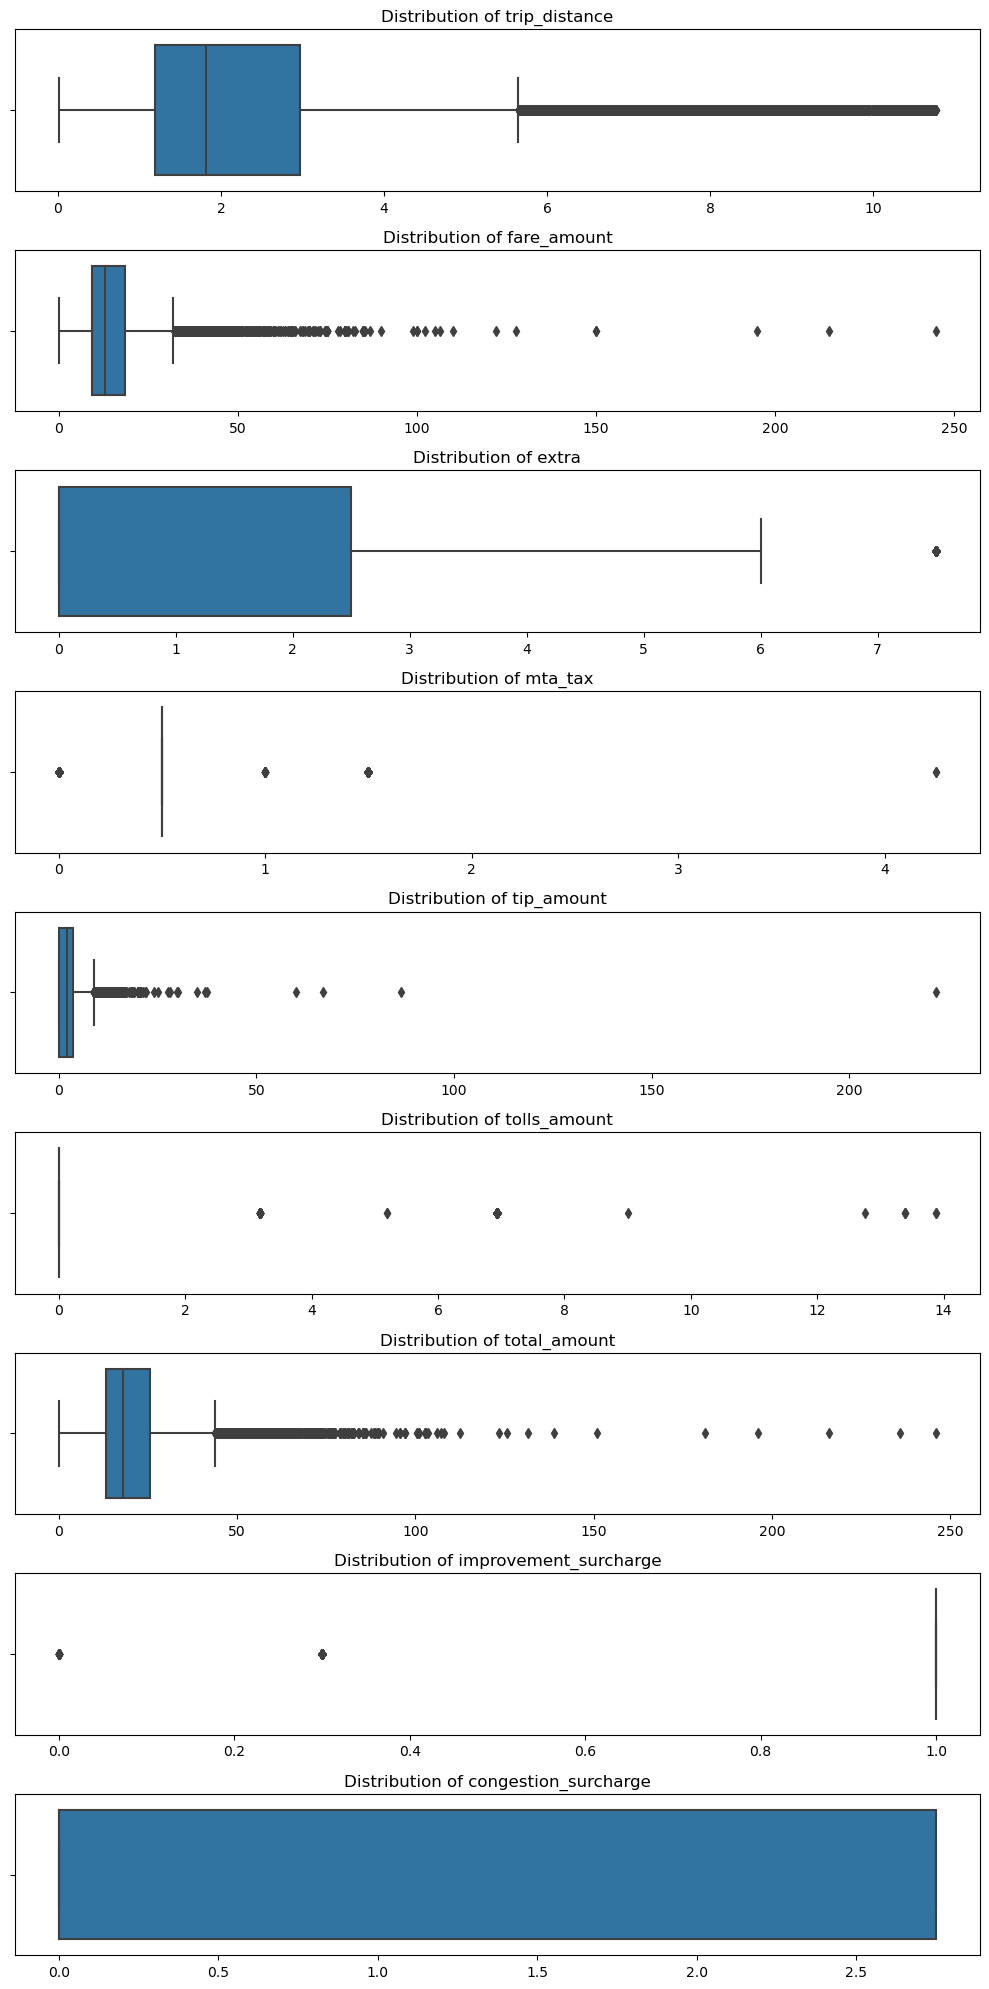

In [11]:
# Data columns for EDA
eda_columns = ['trip_distance', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'total_amount', 'improvement_surcharge', 'congestion_surcharge']

# Plotting distributions of key numerical variables to identify outliers and data quality issues
fig, axes = plt.subplots(len(eda_columns), 1, figsize=(10, 20))

for i, col in enumerate(eda_columns):
    sns.boxplot(x=green_taxi_data[col], ax=axes[i]).set_title(f'Distribution of {col}', fontsize=12)
    axes[i].set_xlabel('')

plt.tight_layout()
plt.show()

`Trip Distanc`: There appear to be several extreme values, which might indicate unusually long trips.

`Fare Amount`: Similar to trip distance, there are extreme values that could suggest overcharges or special cases like long-haul trips.

`Extra`: Most values are clustered near zero, but there are some outliers.

`MTA Tax`: Most data points are at expected tax values, but there are some inconsistencies that should be examined.

`Tip Amount`: There is a wide range of tips, including some very high values.

`Tolls Amount`: Most trips do not include tolls, but there are significant outliers where tolls are high.

`Total Amount`: Reflects the pattern seen in fare amount and tip amount, with several high outliers.

`Improvement Surcharge`: This fee appears consistent, though there are a few anomalies.

`Congestion Surcharge`: Most values are consistent, but there are a few outliers.

In [12]:
# Define a function to treat outliers using the IQR method
def treat_outliers(df, column):
    # Calculate Q1, Q3 and IQR
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    # Define bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Treat outliers by capping
    df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
    df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])
    return df

# Applying the outlier treatment to the selected columns
for col in eda_columns:
    green_taxi_data = treat_outliers(green_taxi_data, col)

#### **Data consistency check**

A consistency check was performed on `total_amount` by calculating the calculated total amount derived from the sum of the cost components and comparing it to the original total_amount to identify and adjust for small discrepancies. For large discrepancies, records were flagged for review.

In [13]:
# Now, perform data consistency checks for 'total_amount'
green_taxi_data['calculated_total'] = (green_taxi_data['fare_amount'] +
                                       green_taxi_data['extra'] +
                                       green_taxi_data['mta_tax'] +
                                       green_taxi_data['tip_amount'] +
                                       green_taxi_data['tolls_amount'] +
                                       green_taxi_data['improvement_surcharge'] +
                                       green_taxi_data['congestion_surcharge'])

# Check for discrepancies in 'total_amount'
green_taxi_data['total_discrepancy'] = green_taxi_data['total_amount'] - green_taxi_data['calculated_total']
discrepancy_mask = np.abs(green_taxi_data['total_discrepancy']) > 0.01  # Allow for slight rounding differences
discrepancies = green_taxi_data[discrepancy_mask]

# Display the first few discrepancies to assess
discrepancies.head(), discrepancies['total_discrepancy'].describe()

(    VendorID lpep_pickup_datetime lpep_dropoff_datetime store_and_fwd_flag  \
 1          2  2024-01-31 22:59:22   2024-01-31 23:27:14                  N   
 8          2  2024-02-01 00:00:54   2024-02-01 00:11:36                  N   
 9          2  2024-02-01 00:33:58   2024-02-01 00:55:06                  N   
 14         2  2024-02-01 00:09:27   2024-02-01 00:30:25                  N   
 22         2  2024-02-01 01:42:46   2024-02-01 02:09:20                  N   
 
     RatecodeID  PULocationID  DOLocationID  passenger_count  trip_distance  \
 1          1.0            43           242              1.0           5.64   
 8          5.0            92           223              1.0           5.64   
 9          1.0           255            48              5.0           5.10   
 14         5.0            42           250              1.0           5.64   
 22         1.0            83            76              1.0           5.64   
 
     fare_amount  ...  mta_tax  tip_amount  toll

**Discrepancy Summary**

Discrepancy Count: 6,712 entries show some degree of discrepancy.

Mean Variance: approximately 0.71, indicating that the mean variance in the records slightly overestimates total_amount.

Standard deviation: 3.66, indicating variability in the differences.

Variance range: from -6.53 to +26.02, indicating undercharging and overcharging relative to the sum of components.

In [14]:
# Defining the threshold for minor and major discrepancies
threshold_minor = 1.00

# Adjusting 'total_amount' for minor discrepancies
green_taxi_data.loc[abs(green_taxi_data['total_discrepancy']) <= threshold_minor, 'total_amount'] = green_taxi_data['calculated_total']

# Flagging records with major discrepancies for review
green_taxi_data['flag_for_review'] = abs(green_taxi_data['total_discrepancy']) > threshold_minor

# Count of adjustments and flags
adjustments_count = (abs(green_taxi_data['total_discrepancy']) <= threshold_minor).sum()
flags_count = (abs(green_taxi_data['total_discrepancy']) > threshold_minor).sum()

adjustments_count, flags_count

(42189, 4619)

**Adjustments made**: A total of 42,189 records had their total_amount adjusted to align with the calculated totals where the variance was within the $1.00 threshold.

**Records Flagged for Review**: approximately 4,619 records were flagged for further review due to variances over $1.00, which according to the Green Trips Data Dictionary (May 1, 2018) may be due to cash tips not being credited, so we consider these records to be reasonable data here.

#### **Time feature introduction**

Based on typical urban traffic patterns, define the morning and evening peak hours and introduce `rush_hour_flag` for each row in the data.

Based on the sunrise and sunset times in February in New York, define the night time period and introduce `night_flag`.

Extract days of the week from `lpep_pickup_datetime` and add `day_of_week` column.

In [15]:
# Define rush hour time range based on typical urban traffic patterns
rush_hour_morning_start = pd.to_datetime('6:30').time()
rush_hour_morning_end = pd.to_datetime('9:30').time()
rush_hour_evening_start = pd.to_datetime('16:00').time()
rush_hour_evening_end = pd.to_datetime('19:00').time()

# Create 'rush_hour_flag'
green_taxi_data['rush_hour_flag'] = green_taxi_data['lpep_pickup_datetime'].apply(
    lambda x: (rush_hour_morning_start <= x.time() <= rush_hour_morning_end) or 
              (rush_hour_evening_start <= x.time() <= rush_hour_evening_end)
).astype(int)  # Convert to 0 and 1

# Define night time range based on the provided sunrise and sunset times
sunset = pd.to_datetime('17:09').time()
sunrise = pd.to_datetime('07:11').time()

# Create 'night_flag'
green_taxi_data['night_flag'] = green_taxi_data['lpep_pickup_datetime'].apply(
    lambda x: (x.time() > sunset) or (x.time() < sunrise)
).astype(int)  # Convert to 0 and 1

# Extract day of the week from the 'lpep_pickup_datetime' (Monday=0, Sunday=6)
green_taxi_data['day_of_week'] = green_taxi_data['lpep_pickup_datetime'].dt.dayofweek

# Check the first few rows to confirm creation of new variables
print(green_taxi_data[['rush_hour_flag', 'night_flag', 'day_of_week']].head())

   rush_hour_flag  night_flag  day_of_week
0               0           1            3
1               0           1            2
2               0           1            3
3               0           1            2
5               0           1            3


#### **Stability Tests**

Augmented Dickey-Fuller (ADF) tests were performed on key variables to check the stability of the data.

In [16]:
# Function to run Augmented Dickey-Fuller test on a series
def test_stationarity(series, signif=0.05, name=''):
    # Check if the series is constant
    if series.nunique() == 1:  # all values are the same
        print(f"Skipping stationarity test for {name} because it is constant.")
        return

    r = adfuller(series.dropna(), autolag='AIC') # Ensure series has no NA values
    output = {
        'test_statistic': round(r[0], 4), 
        'pvalue': round(r[1], 4), 
        'n_lags': round(r[2], 4), 
        'n_obs': r[3]
    }
    p_value = output['pvalue'] 
    print(f'Augmented Dickey-Fuller Test on "{name}"')
    print('-----------------------------------------------')
    print(f'Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f'Significance Level = {signif}')
    print(f'Test Statistic = {output["test_statistic"]}')
    print(f'No. Lags Chosen = {output["n_lags"]}')
    print('Critical Values:')
    for key, value in r[4].items():
        print(f'   {key}: {round(value, 3)}')

    if p_value <= signif:
        print("Conclusion: Reject the null hypothesis. Data is stationary.")
    else:
        print("Conclusion: Fail to reject the null hypothesis. Data is non-stationary.")

# Test stationarity for each individual series in dataset
variables_to_test = ['trip_distance', 'fare_amount', 'extra', 'tip_amount', 'total_amount', ]
for variable in variables_to_test:
    test_stationarity(green_taxi_data[variable], name=variable)

Augmented Dickey-Fuller Test on "trip_distance"
-----------------------------------------------
Null Hypothesis: Data has unit root. Non-Stationary.
Significance Level = 0.05
Test Statistic = -22.2538
No. Lags Chosen = 56
Critical Values:
   1%: -3.43
   5%: -2.862
   10%: -2.567
Conclusion: Reject the null hypothesis. Data is stationary.
Augmented Dickey-Fuller Test on "fare_amount"
-----------------------------------------------
Null Hypothesis: Data has unit root. Non-Stationary.
Significance Level = 0.05
Test Statistic = -21.6537
No. Lags Chosen = 56
Critical Values:
   1%: -3.43
   5%: -2.862
   10%: -2.567
Conclusion: Reject the null hypothesis. Data is stationary.
Augmented Dickey-Fuller Test on "extra"
-----------------------------------------------
Null Hypothesis: Data has unit root. Non-Stationary.
Significance Level = 0.05
Test Statistic = -7.4288
No. Lags Chosen = 45
Critical Values:
   1%: -3.43
   5%: -2.862
   10%: -2.567
Conclusion: Reject the null hypothesis. Data is 

The output provided details the results of the augmented Dickey-Fuller test, confirming that all of the variables tested are smooth except for `tolls_amount` (which was skipped due to constancy). This indicates that there is no unit root in these time series and that their mean, variance and autocorrelation structures do not vary over time.

#### **Multicollinearity Checking**

Calculates and displays correlation matrices for selected variables, as well as Durbin-Watson statistics, to check for possible multicollinearity problems.

In [17]:
# Check for correlation to test for multicollinearity
variables_of_interest = ['trip_distance', 'fare_amount', 'extra', 'tip_amount', 'total_amount', 'rush_hour_flag', 'night_flag', 'day_of_week']
X = green_taxi_data[variables_of_interest]
correlation_matrix = X.corr()

# Display the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

# Calculate and display Durbin-Watson statistics
print("Durbin-Watson Statistics:")
durbin_watson_results = {variable: durbin_watson(X[variable]) for variable in variables_of_interest}
for variable, dw_stat in durbin_watson_results.items():
    print(f'{variable}: {dw_stat:.2f}')

Correlation Matrix:
                trip_distance  fare_amount     extra  tip_amount  \
trip_distance        1.000000     0.922062  0.108451    0.399044   
fare_amount          0.922062     1.000000  0.065598    0.405345   
extra                0.108451     0.065598  1.000000    0.141342   
tip_amount           0.399044     0.405345  0.141342    1.000000   
total_amount         0.890744     0.952672  0.208364    0.593057   
rush_hour_flag      -0.050662    -0.035249  0.297598    0.029440   
night_flag          -0.010961    -0.046797  0.369117    0.008047   
day_of_week          0.037897     0.028899 -0.130064    0.005526   

                total_amount  rush_hour_flag  night_flag  day_of_week  
trip_distance       0.890744       -0.050662   -0.010961     0.037897  
fare_amount         0.952672       -0.035249   -0.046797     0.028899  
extra               0.208364        0.297598    0.369117    -0.130064  
tip_amount          0.593057        0.029440    0.008047     0.005526  
total_a

Correlation Matrix Observations:

The high correlation `fare_amount`: , `total_amount` and There is a high correlation between `trip_distance`, which is expected because these variables are directly related to trip cost and length. the correlation total_amount between `fare_amount` and `total_amount` is particularly strong (0.95), suggesting that there is redundancy between these variables.

Low or insignificant correlations: the relatively low correlations between `rush_hour_flag` and `night_flag` and other financial indicators may indicate that these time-based flags do not directly and significantly affect fare amounts, or that their effects are more subtle and require further investigation.

Durbin-Watson Statistical Interpretation:

Values close to 2: The ideal Durbin-Watson statistic is close to 2, indicating no autocorrelation. Most variables show statistics that deviate from this ideal, indicating a potential positive or negative autocorrelation.

The lower values: `fare_amount`(0.39), `total_amount`(0.35) and `trip_distance`(0.59) show values well below 2, indicating positive autocorrelation. This means that successive observations are positively correlated with each other, which is typical for financial data related to services such as taxis, where the travelling characteristics of such services may not change significantly in the short term.

The value `tolls_amount` for Tolls: NaN indicates a problem due to the constant nature of the data, or that there is no data available to calculate statistics.

<a id="ID_analyse"></a>
| [1.0 Intro](#ID_intr) | [2.0 Lit. review & RQ](#ID_lit) | [3.0 Method](#ID_method) | [4.0 Data](#ID_data) | [5.0 Explore]("#section_ID") | [6.0 Analysis](#ID_Intro) | [7.0 Results]("#section_ID") | [8.0 Discussion](#ID_Intro) | [Bibliography](#ID_Intro) | [Appendix](#ID_Intro) |

## 6.0 | Analysis

### Dimensionality reduction (PCA)

To address multicollinearity and autocorrelation, we will further refine and explain the key variables in our New York City Green Taxi dataset by utilising Principal Component Analysis (PCA), a powerful dimensionality reduction technique that helps us to identify which factors have the greatest impact on drivers' tipping revenues by extracting the main sources of variation in the data. This analysis will not only simplify our dataset, but will also allow us to see more clearly the interactions between different features and their combined impact on tipping behaviour.

**Feature selection and normalisation**: relevant features are selected from the raw data and these features are normalised to ensure that each feature has equal importance in the analysis.

**Perform PCA**: Apply PCA in order to extract principal components, which helps to distil the most important information from the multidimensional feature space.

In [18]:
# Selecting relevant columns for PCA
features = ['trip_distance', 'fare_amount', 'extra', 'total_amount', 'rush_hour_flag', 'night_flag', 'day_of_week']
X = green_taxi_data[features].values

# Standardizing the features
X_scaled = StandardScaler().fit_transform(X)

# Performing PCA
pca = PCA(random_state=10)
X_pca = pca.fit_transform(X_scaled)

# Create a DataFrame for principal components
df_principal_components = pd.DataFrame(pca.components_, columns=features)

# Explained variance ratio and eigenvalues
explained_variance_ratio = pca.explained_variance_ratio_
explained_variance = pca.explained_variance_

# Showing the principal components as a DataFrame
df_principal_components, explained_variance_ratio, explained_variance

(   trip_distance  fare_amount     extra  total_amount  rush_hour_flag  \
 0       0.566150     0.576961  0.117516      0.576621       -0.003000   
 1      -0.064696    -0.090723  0.677368      0.015998        0.474967   
 2       0.011632    -0.023897  0.033688     -0.023128       -0.350325   
 3      -0.013216     0.012633 -0.060476      0.006572        0.714640   
 4      -0.056116    -0.098067  0.714780      0.008679       -0.374181   
 5       0.800454    -0.253304  0.042155     -0.540343        0.030741   
 6       0.176359    -0.764444 -0.099412      0.612069        0.001945   
 
    night_flag  day_of_week  
 0    0.008588     0.014323  
 1    0.513437    -0.198214  
 2    0.565288     0.745215  
 3   -0.347978     0.603462  
 4   -0.543511     0.202070  
 5   -0.016013    -0.012695  
 6   -0.002843    -0.000705  ,
 array([0.41006584, 0.21604249, 0.15282547, 0.1274861 , 0.07311183,
        0.01575778, 0.0047105 ]),
 array([2.87052221, 1.51232974, 1.06980112, 0.89242176, 0.51179

The **principal component loading matrix** shows the weights of the original variables on the principal components, and these weights reveal the composition of each principal component. For example, PC1 consists mainly of positive contributions from `trip_distance`, `fare_amount`, and `total_amount`, indicating that these cost-related variables play a major role in passenger tip giving.PC2 has high positive loadings on `extra` and `rush_hour_flag`, while `night_flag` has high positive loadings on PC2 also loads significantly on PC2, and the combination of indicated time and extra with other characteristics also has an effect on passenger tipping behaviour.

**Explained variance analysis**: Determine which components to retain will provide the most useful information by analysing the proportion of explained variance for each principal component.

**Visualisation**: Visualising the results of principal component analysis through visualisation techniques (e.g. biscuits and explained variance plots) to further analyse the contribution of each principal component to the research question.

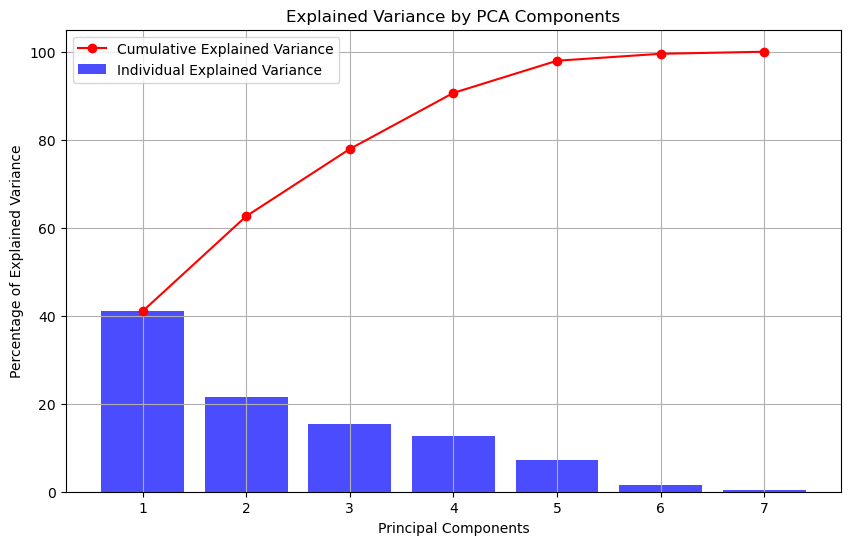

In [19]:
# Creating the plot for the explained variance ratio of the PCA components again
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_ * 100, alpha=0.7, color='blue')
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Components')
plt.title('Explained Variance by PCA Components')
plt.xticks(range(1, len(pca.explained_variance_ratio_) + 1))
plt.grid(True)

# Adding a cumulative sum line
cumulative_variance = np.cumsum(pca.explained_variance_ratio_) * 100
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), cumulative_variance, marker='o', linestyle='-', color='red')
plt.legend(['Cumulative Explained Variance', 'Individual Explained Variance'])

plt.show()

The **variance explained plot** shows the percentage of variance explained by each component of the PCA analysis. As can be seen from the graph, the first principal component explains more than 40% of the variance, while accumulating to the second principal component explains about 62% of the variance. This suggests that the first two principal components alone capture most of the data variability, providing most of the information about the data after dimensionality reduction.

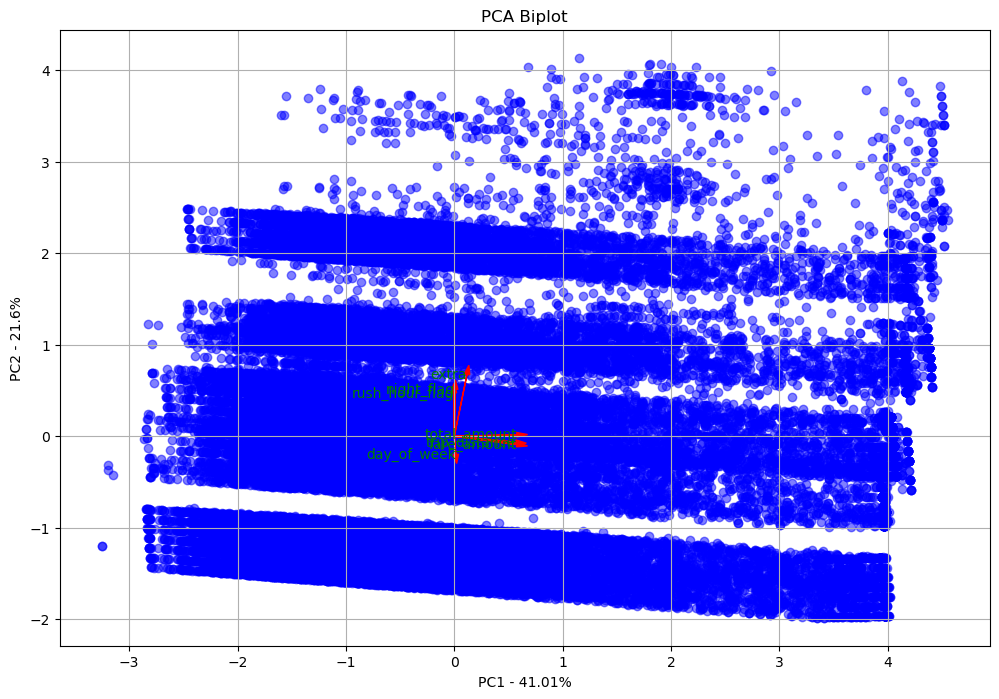

In [20]:
# Biplot
plt.figure(figsize=(12, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5, color='blue')
for i, var in enumerate(features):
    plt.arrow(0, 0, pca.components_[0, i], pca.components_[1, i], head_width=0.05, head_length=0.1, color='red')
    plt.text(pca.components_[0, i], pca.components_[1, i], var, color='green', ha='right', va='center')

plt.xlabel('PC1 - {}%'.format(round(explained_variance_ratio[0]*100, 2)))
plt.ylabel('PC2 - {}%'.format(round(explained_variance_ratio[1]*100, 2)))
plt.title('PCA Biplot')
plt.grid(True)
plt.show()

The **biplot** shows the contribution of the original variables to the first and second principal components in two dimensions. Each arrow represents a variable, and the direction and length of the arrow indicates the contribution and direction of the principal component corresponding to that variable. In the biscaled plot, trip_distance, fare_amount, and total_amount are closely aligned, indicating a positive correlation between them, as well as being in the same direction as PC1, suggesting that they are the main factors in tipping behaviour. the direction of rush_hour_flag and night_flag suggests that temporal features play an also plays an important role in the influence of tipping behaviour, especially on PC2.

### Panel regression

After completing the Principal Component Analysis (PCA), in order to further analyse the effects of trip characteristics and time factors on green taxi driver tips, we will use a panel regression model. Panel regression is an efficient method of statistical analysis that allows us to consider both time-series data and cross-sectional data, which is particularly important when dealing with taxi trip data that has both a time dimension and an individual dimension.

#### **Model Selection and Setup:**
**Selection of principal components**<br>
Based on the results of the component matrix analysis, variance explained plot, and double labelled plots, we identified two principal components from PCA which will be used as explanatory variables (independent variables) to simplify the model and reduce multicollinearity.

**Dependent variable setting**<br>
Select `tip_amount` as dependent variable (dependent variable), which is the main point of interest of our analysis.

        PC1       PC2
0  0.230170  0.204788
1  3.758948 -0.013716
2 -1.438463  0.332972
3 -0.742095  0.390010
4 -2.243850  0.388195


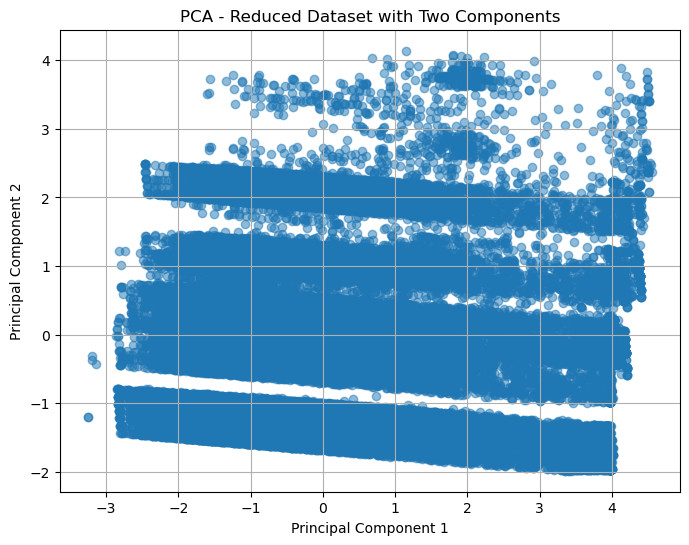

In [21]:
# Number of components to keep
n_components_to_keep = 2

# Initialize PCA with the chosen number of components
pca_selected = PCA(n_components=n_components_to_keep, random_state=10)

# Fit and transform the standardized features using PCA
X_pca_selected = pca_selected.fit_transform(X_scaled)

# Now X_pca_selected contains the dataset reduced to the first two principal components
# You can convert it into a DataFrame for ease of use
df_pca_selected = pd.DataFrame(X_pca_selected, columns=[f'PC{i+1}' for i in range(n_components_to_keep)])

# Show the new dataframe with the selected principal components
print(df_pca_selected.head())

# Visualize the reduced dataset in 2D plot since we only have two components
plt.figure(figsize=(8, 6))
plt.scatter(df_pca_selected['PC1'], df_pca_selected['PC2'], alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA - Reduced Dataset with Two Components')
plt.grid(True)
plt.show()

In [22]:
# Ensure that X is a DataFrame with proper column names
X_df = pd.DataFrame(X_scaled, columns=features)

# Now we can safely refer to X_df.columns to get the original feature names
loadings = pd.DataFrame(pca_selected.components_.T, columns=df_pca_selected.columns, index=X_df.columns)
print(loadings)

                     PC1       PC2
trip_distance   0.566150 -0.064696
fare_amount     0.576961 -0.090723
extra           0.117516  0.677368
total_amount    0.576621  0.015998
rush_hour_flag -0.003000  0.474967
night_flag      0.008588  0.513437
day_of_week     0.014323 -0.198214


#### **Panel data structure preparation:**
**Data index setting**<br>
Ensure that the index of the DataFrame (DataFrame) is set correctly, usually with `PULocationID` and date `Date` as the index to support the panel data analysis.

**Data Integration**<br>
Merge the component data obtained from PCA with the original dataset, ensuring that all variables are aligned and ready for regression analysis.

In [23]:
# First, convert the pickup datetime to a suitable format if it's not already in one.
green_taxi_data['lpep_pickup_datetime'] = pd.to_datetime(green_taxi_data['lpep_pickup_datetime'])

# Extract the date from 'lpep_pickup_datetime' for daily aggregation.
green_taxi_data['Date'] = green_taxi_data['lpep_pickup_datetime'].dt.date

# Group by 'PULocationID' and 'Date' and count the number of records.
unique_counts = green_taxi_data.groupby(['PULocationID', 'Date']).size()

# Now check the number of unique dates for each 'PULocationID'.
unique_dates_per_location = unique_counts.reset_index().groupby('PULocationID').size()

# If there's any 'PULocationID' that has only one unique date, it's not suitable for panel data.
not_unique = unique_dates_per_location[unique_dates_per_location == 1]

# Print the results
print(f"The number of 'PULocationID' entries that have only one record per day: {not_unique.count()}")


The number of 'PULocationID' entries that have only one record per day: 27


#### **Panel regression analyses were performed:**

**Fixed effects model**<br>
A fixed effects model is used first, which helps to control for all potentially invariant individual-specific variables that may not be directly observable in the model.

In [24]:
# Ensure 'lpep_pickup_datetime' is in datetime format.
green_taxi_data['lpep_pickup_datetime'] = pd.to_datetime(green_taxi_data['lpep_pickup_datetime'])

# Extract the date part from 'lpep_pickup_datetime' and convert it directly to datetime format.
green_taxi_data['Date'] = pd.to_datetime(green_taxi_data['lpep_pickup_datetime'].dt.date)

# Set 'PULocationID' and 'Date' as the index.
if 'PULocationID' in green_taxi_data.columns and 'Date' in green_taxi_data.columns:
    green_taxi_data.set_index(['PULocationID', 'Date'], inplace=True)
    print("Index set with PULocationID and Date.")
else:
    print("PULocationID or Date column not found in DataFrame.")

# Check the data types of the indices to confirm they are set correctly
print("Data types of the index levels:")
print(green_taxi_data.index.get_level_values('PULocationID').dtype)
print(green_taxi_data.index.get_level_values('Date').dtype)

# Align PCA DataFrame index with the main DataFrame
try:
    df_pca_selected.index = green_taxi_data.index
    print("PCA DataFrame index aligned with main DataFrame.")
except Exception as e:
    print("Error in aligning PCA DataFrame index:", e)

# Assuming 'tip_amount' is the dependent variable and exists in the DataFrame
try:
    Y = green_taxi_data['tip_amount']
    print("Dependent variable set.")
except KeyError:
    print("Column 'tip_amount' not found in DataFrame.")

# Add a constant to the PCA components
try:
    X = df_pca_selected  # Use PCA components
    X = sm.add_constant(X)
    print("Independent variables set with constant.")

    # Fit the panel regression model
    mod = PanelOLS(Y, X, entity_effects=True)
    res = mod.fit()
    print("Panel regression model fit successfully.")
    print(res.summary)
except Exception as e:
    print("Error fitting the model:", e)

Index set with PULocationID and Date.
Data types of the index levels:
int32
datetime64[ns]
PCA DataFrame index aligned with main DataFrame.
Dependent variable set.
Independent variables set with constant.
Panel regression model fit successfully.
                          PanelOLS Estimation Summary                           
Dep. Variable:             tip_amount   R-squared:                        0.2413
Estimator:                   PanelOLS   R-squared (Between):             -0.5395
No. Observations:               46808   R-squared (Within):               0.2413
Date:                Mon, Apr 29 2024   R-squared (Overall):              0.2356
Time:                        02:11:43   Log-likelihood                -9.653e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      7414.1
Entities:                         177   P-value                           0.0000
Avg Obs:                 

The fixed-effects model revealed that principal components 1 and 2 had a significant positive effect on tip amount, and the model explained a reasonable portion of the data variability (R-squared of 0.2413). The model accounted for the unique effect of each pickup location (`PULocationID`), revealing that there was a significant difference in tip amounts between locations.

**Random effects model**<br>
For comparison purposes, it is also possible to use a random effects model, especially if we believe that the individual effects are not correlated with the explanatory variables.
Model comparison and selection: statistical methods such as the Hausman test are used to determine which model (fixed or random effects) is more appropriate for our data.

In [25]:
model_re = RandomEffects(Y, X)
res_re = model_re.fit()
print(res_re.summary)

                        RandomEffects Estimation Summary                        
Dep. Variable:             tip_amount   R-squared:                        0.2419
Estimator:              RandomEffects   R-squared (Between):             -0.0341
No. Observations:               46808   R-squared (Within):               0.2413
Date:                Mon, Apr 29 2024   R-squared (Overall):              0.0543
Time:                        02:11:43   Log-likelihood                -9.663e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      7469.0
Entities:                         177   P-value                           0.0000
Avg Obs:                       264.45   Distribution:                 F(2,46805)
Min Obs:                       1.0000                                           
Max Obs:                    1.106e+04   F-statistic (robust):             7411.1
                            

The random effects model similarly found a positive effect of principal components 1 and 2 on tip amount, but the explanatory power of the model was slightly different due to its inclusion of random individual effects. The overall R-squared was low (0.0543), which may indicate that random differences between individuals have less of an effect on tip amounts than the fixed effects model.

#### **Model comparison and selection:**
Statistical methods such as the Hausman test are used to determine which model (fixed or random effects) is more appropriate for our data.

In [26]:
# Hausman test
# Extract parameters and covariance matrices for significant predictors only
b_fe = res.params[['PC1', 'PC2']]
b_re = res_re.params[['PC1', 'PC2']]
v_fe = res.cov.loc[['PC1', 'PC2'], ['PC1', 'PC2']]
v_re = res_re.cov.loc[['PC1', 'PC2'], ['PC1', 'PC2']]

# Calculate the difference in coefficients and the variance-covariance matrix
b_diff = b_fe - b_re
v_diff = v_fe - v_re

# Calculate the chi-squared statistic
chi2 = b_diff.T @ np.linalg.inv(v_diff) @ b_diff

# Degrees of freedom: number of significant predictors
df = len(b_diff)

# Calculate the p-value
pval = 1 - stats.chi2.cdf(chi2, df)

# Create a summary table of results
table = pd.DataFrame({
    'Fixed Effects': b_fe,
    'Random Effects': b_re,
    'Difference': b_diff,
    'Standard Errors (FE)': np.sqrt(np.diag(v_fe)),
    'Standard Errors (RE)': np.sqrt(np.diag(v_re))
})

print(table)
print(f'\nChi-Squared: {chi2:.2f}')
print(f'Degrees of Freedom: {df}')
print(f'P-Value: {pval:.5f}')

     Fixed Effects  Random Effects  Difference  Standard Errors (FE)  \
PC1       0.657225        0.656017    0.001208              0.005429   
PC2       0.095850        0.096285   -0.000435              0.007324   

     Standard Errors (RE)  
PC1              0.005420  
PC2              0.007319  

Chi-Squared: 16.07
Degrees of Freedom: 2
P-Value: 0.00032


The results of the Hausman test (chi-square value of 16.07, degree of freedom of 2, p-value of 0.00032) rejected the applicability of the random effects model and supported the use of the fixed effects model. This implies that the explanatory variables in the model are likely to be correlated with individual effects and therefore the fixed effects model is a more appropriate choice when analysing these data.

#### **Model testing and diagnostics**

To test the fixed effects model, we performed diagnostic tests for heteroskedasticity and serial correlation to assess the statistical properties of the regression model residuals.

In [27]:
# Heteroscedasticity Tests
residuals = res.resids.values.flatten()  # Flatten the residuals
exog = pd.DataFrame(res.model.exog.dataframe)  # Convert exog to DataFrame

# Breusch-Pagan test
bp_test = het_breuschpagan(residuals, exog)
print('Breusch-Pagan test -- p-value:', bp_test[1])

# White test for heteroscedasticity
white_test = het_white(residuals, exog)
print('White test -- p-value:', white_test[1])

# Serial Correlation Test
dw = durbin_watson(res.resids)
print('Durbin-Watson statistic:', dw)

Breusch-Pagan test -- p-value: 0.0
White test -- p-value: 0.0
Durbin-Watson statistic: 1.9912046278497386


The p-value for both the Breusch-Pagan and White tests is 0.0, indicating heteroscedasticity of the residuals.The Durbin-Watson statistic value is close to 2, implying that there is no significant autocorrelation problem.

Then, perform Pesaran's cross-sectional independence test, which is used to assess cross-sectional correlations in the model residuals.

In [28]:
from scipy.stats import t as t_dist  # Importing with an alias to avoid any potential conflicts

def pesaran_cd_test(residuals, T, N):
    """
    Perform Pesaran's test of cross-sectional independence.

    Parameters:
    residuals -- numpy array of residuals from a panel data model.
    T -- int, number of time periods.
    N -- int, number of cross-sectional units.

    Returns:
    CD statistic and p-value.
    """
    cd_stat = 0
    # Compute average correlation for each time period
    for t in range(T):
        res_t = residuals[t::T]
        corr_matrix = np.corrcoef(res_t)
        corr_sum = np.sum(corr_matrix) - N  # Subtract N because we don't include diagonal elements (self-correlation)
        cd_stat += corr_sum / (N - 1)
    
    cd_stat = np.sqrt(T / (N * (N - 1))) * cd_stat
    p_value = 2 * (1 - t_dist.cdf(abs(cd_stat), df=(T - 1)))  # Use the alias for the t distribution
    return cd_stat, p_value

T = green_taxi_data.index.get_level_values('Date').nunique()  # number of time periods
N = green_taxi_data.index.get_level_values('PULocationID').nunique()  # number of entities

cd_stat, p_value = pesaran_cd_test(residuals, T, N)
print("Pesaran CD Test Statistic:", cd_stat)
print("P-value:", p_value)

Pesaran CD Test Statistic: -1.025609418342735
P-value: 0.313012575840079


The Pesaran CD test statistic value of -1.0256, which corresponds to a p-value of 0.3130, indicates that there is insufficient evidence to reject the hypothesis of cross-sectional independence, i.e., there is no significant cross-sectional correlation between the model residuals.

#### **Model optimisation**
To increase the model residual variance resistance, robust regression methods were used, which are designed to be less sensitive to outliers.

In [29]:
# Solve heteroscedasticity
new_mod = PanelOLS(Y, X, entity_effects=True)
new_res = new_mod.fit(cov_type='robust')
print(new_res)

                          PanelOLS Estimation Summary                           
Dep. Variable:             tip_amount   R-squared:                        0.2413
Estimator:                   PanelOLS   R-squared (Between):             -0.5395
No. Observations:               46808   R-squared (Within):               0.2413
Date:                Mon, Apr 29 2024   R-squared (Overall):              0.2356
Time:                        02:11:43   Log-likelihood                -9.653e+04
Cov. Estimator:                Robust                                           
                                        F-statistic:                      7414.1
Entities:                         177   P-value                           0.0000
Avg Obs:                       264.45   Distribution:                 F(2,46629)
Min Obs:                       1.0000                                           
Max Obs:                    1.106e+04   F-statistic (robust):             3895.1
                            

The results of the fixed-effects model using robust covariance estimation confirm that principal components 1 and 2 still have a significant positive effect on the amount of tips given to New York City green taxi drivers after accounting for potential heteroskedasticity, and that the model's inclusion of individual effects is statistically plausible, which provides robust evidence for understanding the key factors that influence driver tipping.

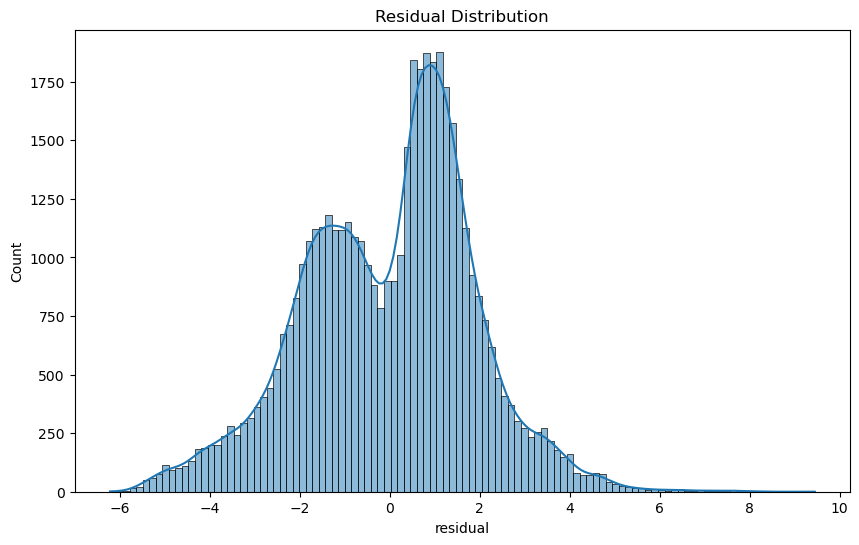

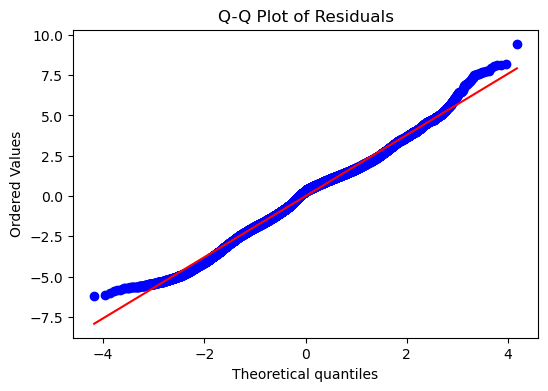

In [30]:
# Residual diagnostics
residuals = new_res.resids
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title('Residual Distribution')
plt.show()

# Q-Q plot
fig, ax = plt.subplots(figsize=(6, 4))
stats.probplot(residuals, dist="norm", plot=ax)
plt.title("Q-Q Plot of Residuals")
plt.show()

The histogram shows a distribution with multiple peaks and heavy tails, which indicates that the residuals are not normally distributed.
The QQ plot of the residuals shows deviations from the reference line, especially at the ends of the distribution, which indicates the presence of heavy tails. This is further evidence that the residuals are not normally distributed.

Investigate whether the violation of normality in the residuals is severe enough to undermine the conclusions of the model. In many cases, if the sample size is large (as seems to be the case with 46,808 observations), the central limit theorem may imply that the parameter estimates are valid despite the non-normality.

In [31]:
# Statistical tests for normality
shapiro_test = stats.shapiro(residuals)
ks_test = stats.kstest(residuals, 'norm')

# Check the skewness and kurtosis
skewness = stats.skew(residuals)
kurtosis = stats.kurtosis(residuals)

print(f"Shapiro-Wilk test p-value: {shapiro_test.pvalue}")
print(f"Kolmogorov-Smirnov test p-value: {ks_test.pvalue}")
print(f"Skewness: {skewness}")
print(f"Kurtosis: {kurtosis}")

Shapiro-Wilk test p-value: 3.783505853677006e-44
Kolmogorov-Smirnov test p-value: 0.0
Skewness: -0.15564614724824274
Kurtosis: 0.12432743370451149


Normality tests (Shapiro-Wilk and Kolmogorov-Smirnov) indicate that the residuals do not follow a normal distribution, but the values of skewness and kurtosis are close to 0, suggesting that deviations from normality may not be severe. The central limit theorem in large samples ensures that the sampling distribution of the estimates is normally distributed, allowing p-values and confidence intervals to remain reliable. Despite the non-normality of the residuals, the model is still usable if it has good explanatory power and predictive accuracy.

<a id="ID_conclude"></a>
| [1.0 Intro](#ID_intr) | [2.0 Lit. review & RQ](#ID_lit) | [3.0 Method](#ID_method) | [4.0 Data](#ID_data) | [5.0 Explore]("#section_ID") | [6.0 Analysis](#ID_Intro) | [7.0 Results]("#section_ID") | [8.0 Discussion](#ID_Intro) | [Bibliography](#ID_Intro) | [Appendix](#ID_Intro) |

## 7.0 | Discussion and conclusion

In conclusion, this study reveals that the major components of trip characteristics have a significant positive effect on drivers' tip income. Additionally, time factors such as peak hour and night time markers also influenced tips, but to a lesser extent than trip cost.

    RQ  | How do trip characteristics and time of day factors affect tip income of green taxi drivers in New York City?
    RQ1 | How do trip distance, total cost, other, etc. costs affect tipping?
    RQ2 | How do different times of the day (e.g., morning rush, evening rush, nighttime) and different days of the week affect tipping?

**A1**: Trip cost-related factors (e.g., trip distance and tolls) are determinants in tip income, and their increase tends to lead to higher tips.

**A2**: Peak hour markers and night time markers are positively correlated with tip amounts, implying that different times of the day and different Sundays affect tipping differently, reflecting the fact that tipping is related to daily travel patterns.

<a id="ID_biblio"></a>
| [1.0 Intro](#ID_intr) | [2.0 Lit. review & RQ](#ID_lit) | [3.0 Method](#ID_method) | [4.0 Data](#ID_data) | [5.0 Explore]("#section_ID") | [6.0 Analysis](#ID_Intro) | [7.0 Results]("#section_ID") | [8.0 Discussion](#ID_Intro) | [Bibliography](#ID_Intro) | [Appendix](#ID_Intro) |


***
## Bibliography

Al-Wreikat, Y., Serrano, C., & Sodré, J.R. (2022). Effects of ambient temperature and trip characteristics on the energy consumption of an electric vehicle. Energy, 238, p.122028.

Correa, D., & Moyano, C. (2022). Dynamics of the Growth of UBRER vs Green Taxis in Outer Boroughs in New York City. Available at SSRN 4229008.

Khalil, M. A., Khalil, R., & Khalil, M. K. (2022). Environmental, social and governance (ESG) - augmented investments in innovation and firms' value: a fixed-effects panel regression of Asian economies. China Finance Review International, 2022.

Mojtabaee, P., Molavi, M., & Taleai, M. (2019). EXPLORING DRIVING FACTORS OF HIGHER PAID TAXI TRIPS USING ORIGIN–DESTINATION GPS DATA (CASE STUDY: GREEN TAXIS OF NEW YORK CITY). The International Archives of the Photogrammetry, Remote Sensing and Spatial Information Sciences, 42, pp.745-748.

NYC Taxi and Limousine Commission. (2018). Green Trips Data Dictionary: Data Dictionary - LPEP Trip Records. Retrieved from: https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_green.pdf

Phan, Q.-T., Wu, Y.-K., Phan, Q., & Lo, H.-Y. (2023). A Novel Forecasting Model for Solar Power Generation by a Deep Learning Framework With Data Preprocessing and Postprocessing. IEEE Transactions on Industry Applications, 59, 220-231.

Poulsen, L.K., Dekkers, D., Wagenaar, N., Snijders, W., Lewinsky, B., Mukkamala, R.R., & Vatrapu, R. (2016, June). Green cabs vs. uber in new york city. In 2016 IEEE International Congress on Big Data (BigData Congress) (pp. 222-229). IEEE.

Ray, R. S., & Goel, S. (2022). Impact of ESG score on financial performance of Indian firms: static and dynamic panel regression analyses. Applied Economics, 55, 1742-1755.

Reid, D., Jahanshahi, M., & Mockus, A. (2022). The Extent of Orphan Vulnerabilities from Code Reuse in Open Source Software. 2022 IEEE/ACM 44th International Conference on Software Engineering (ICSE), 2104-2115.89c

***

<a id="ID_append"></a>
| [1.0 Intro](#ID_intr) | [2.0 Lit. review & RQ](#ID_lit) | [3.0 Method](#ID_method) | [4.0 Data](#ID_data) | [5.0 Explore]("#section_ID") | [6.0 Analysis](#ID_Intro) | [7.0 Results]("#section_ID") | [8.0 Discussion](#ID_Intro) | [Bibliography](#ID_Intro) | [Appendix](#ID_Intro) |

## Appendix

Link to the original raw data can be found [here](https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page).

Link to the UCL hosted raw data can be found in one drive, [here](https://liveuclac-my.sharepoint.com/:f:/g/personal/zczqy33_ucl_ac_uk/Eg8SZuBQ7_RFrAu-9T3AqbcBvkKUZnhMB7ViyWN7zkCOhg?e=VTE3iy)